## Crack based on Plant-Water-Evaporation-Stress

![Crack_Model](./Crack_Model.pdf)

The model is a set of four partial differential equations describing the dynamics of four state varibles: Stress (S; $mm$), soil water (W; $mm$), evaporation (E; $mm$), and plant density (P; $g/m^{2}$). The full model reads

$\frac{\partial P}{\partial t} = r_P P (\frac{W(1-S)}{1+W} - P) + D_P \mathrm{\Delta P}$,

$\frac{\partial E}{\partial t} = r_E (W - h) (E - e) + D_E \mathrm{\Delta E}$,

$\frac{\partial S}{\partial t} = r_S (S-S_{min}) (S_{critical}-S) (S-S_{max}) + c_S (E - e)$,

$\frac{\partial W}{\partial t} = \frac{c_W}{1+k_W S} - d_E (E - e) W - d_P P \frac{W}{1+W} + D_W\mathrm{\Delta W}$,

where $r_S$ is the maintenance coefficient of the stress, $S_{min}$ is the minimum stress of the soil, $S_{max}$ is the maximum stress of the soil, $S_{critical}$ is the critical cracking stress of the soil, and $c_S$ is the coefficient of stress increase due to increased evaporation; $c_W$ is the input of water, $k_W$ is the influence coefficient of soil stress on water input (There will be more water input at the crack.), $d_E$ is the evaporation rate of soil water, and $d_P$ is the water uptake rate by plants; $r_E$ is the evaporation rate of soil water and $h$ is the soil moisture content of the critical cracking; $r_P$ is the growth of plant; $D_W$ is the diffusion cofficient of soil water, $D_E$ is the diffusion cofficient of surface water, and $D_P$ is the diffusion cofficient of plant.

Here are the parameters used for the model: $r_S=0.1$, $S_{min}=0.1$, $S_{max}=0.1$, $S_{critical}=0.1$, and $c_S=0.1$; $c_W=0.1$, $k_W=0.1$, $d_E=0.1$, and $d_P=0.1$; $r_E=0.1$ and $h=0.1$; $r_P=0.1$; $D_W=0.1$, $D_E=0.1$, and $D_P=0.1$.

In [1]:
#E：地表空气中的含水量。r*（W-E）蒸发速率 地表水

### Loading some crucial python packages

In [2]:
import time,os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# Widening the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

rcParams['figure.dpi'] = 200
rcParams['font.size'] = 16
rcParams['font.family'] = 'StixGeneral'
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=16)   # fontsize of the figure title

### Parameter definitions 
Here, the parameters that are found in the equations are given their value. For completeness, also their units and explanations are given.

In [3]:
#Stress
rS   = 0.03
Smin = 0.0001 #dm
Smax = 0.3    #dm
Scri = 0.15   #dm
cS   = 0.00015
#Water
cW   = 0.00225
kW   = 20.0
dE   = 0.0025
dP   = 0.0039
DW   = 0.03
#Evaporation
rE   = 0.025
h    = 1.0
DE   = 0.015
#Plant
rP   = 0.025
DP   = 0.0015

# #Stress
# rS   = 0.03
# Smin = 0.0
# Smax = 0.3
# Scri = 0.15
# cS   = 0.00015
# #Water
# cW   = 0.00225
# kW   = 20.0
# dE   = 0.0025
# dP   = 5.2*0.00075
# DW   = 0.03
# #Evaporation
# rE   = 0.025
# h    = 1.0
# DE   = 0.015
# #Plant
# rP   = 0.025
# DP   = 0.0015

### Simulation settings

In [4]:
length    = 1024.0    # 2.5 Length of the physical landscape
n         = 1024      # Size of the 2D grid
endtime   = 30000.0  #end time
dT        = 1.0      #0.02     #calculate time step
nplot     = 300
nsteps    = np.ceil(endtime/nplot/dT).astype(int)   #number of time steps
dX          = length/n   # Spatial step size
dY          = length/n   # Spatial step size
Grid_Width  = n
Grid_Height = n
# %% Reporting in the simulation on the console
print(" Current grid dimensions: %d x %d cells\n" % (Grid_Width, Grid_Height));

 Current grid dimensions: 1024 x 1024 cells



### Defining the device that is used

In [5]:
import pyopencl as cl
# Setting up the OpenCL context
DeviceNr = 1   # 0 = GTX 960M
platform = cl.get_platforms()
Devices  = platform[0].get_devices()  # 0 = GPU
context  = cl.Context([Devices[DeviceNr]])
queue    = cl.CommandQueue(context)
mf       = cl.mem_flags # Memory flags are set
print(" Compute Device: %s\n" % Devices[DeviceNr].name)

 Compute Device: AMD Radeon Pro Vega 64X Compute Engine



### Initial values

In [6]:
# The array is allocated on the GPU and the initial values are copied onto it
# #Stress
# S        = np.ones((n*n),dtype=float)*0.0
# S_host   = S.astype(np.float32)
# S_g      = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=S_host)
# #Water
# W        = np.ones((n*n),dtype=float)*3.0
# W_host   = W.astype(np.float32)
# W_g      = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=W_host)
# #Evaporation
# E        = (np.random.rand(n*n)>0.9996)*1.0+1.0
# E_host   = E.astype(np.float32)
# E_g      = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=E_host)
# #Plant
# P        = np.ones((n*n),dtype=float)*1.0
# P_host   = P.astype(np.float32)
# P_g      = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=P_host)


data_Ps=np.load('Model1Ps.npy')
data_Ss=np.load('Model1Ss.npy')
data_Ws=np.load('Model1Ws.npy')
data_Es=np.load('Model1Es.npy')
S_host  = (data_Ss[:,:,50].reshape(n*n)).astype(np.float32)
S_g     = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=S_host)
W_host  = (data_Ws[:,:,50].reshape(n*n)).astype(np.float32)
W_g     = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=W_host)
E_host  = (data_Es[:,:,50].reshape(n*n)).astype(np.float32)
E_g     = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=E_host)
P_host  = (data_Ps[:,:,50].reshape(n*n)).astype(np.float32)*0.6
P_g     = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=P_host)

### Loading the functions d2_dxy2() and Periodicboundaries()

In [7]:
with open('SpatialFunctions_iPy.cl', 'r') as myfile:
   SpatialFunctions = myfile.read()

### List of parameters for the OpenCL kernel.

In [8]:
# List of parameters for the OpenCL kernel. Seperate with comma without spaces
# Setting up the parameters for the Kernel
PassVars="rS,Smin,Smax,Scri,cS,cW,kW,dE,dP,DW,rE,h,DE,rP,DP,dX,dY,dT,Grid_Width,Grid_Height"

PassVals=eval(PassVars)
PassVars=PassVars.split(',')
Params=""

for ii in range(len(PassVals)):
    Params = Params+"#define " + PassVars[ii] + " " + str(PassVals[ii]) + " \n"

### Defining the OpenCL simulation kernel

In [9]:
ComputeCode = """

///////////////////////////////////////////////////////////////////////////////
// Simulation kernel
///////////////////////////////////////////////////////////////////////////////   

__kernel void SimulationKernel (__global float* S, __global float* W, __global float* E, __global float* P)
{

    size_t current  = get_global_id(0);
    size_t row      = floor((float)current/(float)Grid_Width);
    size_t column   = current%Grid_Width;

        if (row > 0 && row < Grid_Width-1 && column > 0 && column < Grid_Height-1)
            {                
             float dSdt =   rS*(S[current]-Smin)*(S[current]-Smax)*(Scri-S[current]) + cS*(E[current]-1.0);
             float dWdt =   cW/(1.0+kW*S[current]) - dE*(E[current]-1.0)*W[current] - dP*W[current]*P[current]/(1.0+W[current]) + DW*d2_dxy2(W);
             float dEdt =   rE*(W[current] - h)*(E[current]-1.0) + DE*d2_dxy2(E);
             float dPdt =   rP*P[current]*((1.0-S[current])*W[current]/(1.0+W[current]) - P[current]) + DP*d2_dxy2(P);
             
             S[current] = S[current] + dSdt*dT;
             W[current] = W[current] + dWdt*dT;
             E[current] = E[current] + dEdt*dT;
             P[current] = P[current] + dPdt*dT;
             
             //S[current]=(S[current]>0)*S[current];
             //W[current]=(W[current]>0)*W[current];
             //E[current]=(E[current]>0)*E[current];
             //P[current]=(P[current]>0)*P[current];
            }
            
        // HANDLE Boundaries
        else 
            {
             PeriodicBoundaries(S);
             PeriodicBoundaries(W);
             PeriodicBoundaries(E);
             PeriodicBoundaries(P);
            }

} // End SimulationKernel
"""

### Here the kernel is compiled

In [10]:
program = cl.Program(context, Params + SpatialFunctions + ComputeCode).build()

### The main simulation loop

In [11]:
from ipywidgets import FloatProgress
from IPython.display import display

# Setting up a progress bar for the simulation
print("Progress :");
PB = FloatProgress(min=0, max=nplot); display(PB) 

Ss=np.zeros((Grid_Width, Grid_Height, nplot))
Ws=np.zeros((Grid_Width, Grid_Height, nplot))
Es=np.zeros((Grid_Width, Grid_Height, nplot))
Ps=np.zeros((Grid_Width, Grid_Height, nplot))

APB=np.zeros((nplot))
ASB=np.zeros((nplot))
delta=np.zeros((nplot))

# Set up simulation parameters
global_size = P_host.shape

# Start the timer:
start_time = time.time()

# Starting the loop
for ii in range(nplot):
    APB[ii]    = np.mean(P_host.reshape(Grid_Width, Grid_Height))
    ASB[ii]    = np.mean(S_host.reshape(Grid_Width, Grid_Height))
    # The simulation
    for jj in range(nsteps):      
        program.SimulationKernel(queue, global_size, None, S_g, W_g, E_g, P_g)

    # Get the data from the GPU
    cl.enqueue_copy(queue, S_host, S_g)
    cl.enqueue_copy(queue, W_host, W_g)
    cl.enqueue_copy(queue, E_host, E_g)
    cl.enqueue_copy(queue, P_host, P_g)
    
    # We store the state of the system for <NumPlot> different times.
    Ss[:,:,ii] = S_host.reshape(Grid_Width, Grid_Height)
    Ws[:,:,ii] = W_host.reshape(Grid_Width, Grid_Height)
    Es[:,:,ii] = E_host.reshape(Grid_Width, Grid_Height)
    Ps[:,:,ii] = P_host.reshape(Grid_Width, Grid_Height)
    
    PB.value += 1 # signal to increment the progress bar

# Determining the time that we used for the simulation
elapsed_time = time.time() - start_time    
print(" Simulation took      : %1.1f (s)" % (elapsed_time))

Progress :


FloatProgress(value=0.0, max=300.0)

 Simulation took      : 30.7 (s)


### Plotting the results

In [12]:
### The Simulation loop
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
im0 = ax[0].imshow(S_host.reshape(n,n),cmap='YlGn',extent=[0,length,0,length]);#, clim=(0,0.1));
plt.colorbar(im0, ax=ax[0],fraction=0.046,pad=0.04);ax[0].set_title('Stress');

im1 = ax[1].imshow(W_host.reshape(n,n),cmap='YlGn',extent=[0,length,0,length]);#, clim=(0,0.5));
plt.colorbar(im1, ax=ax[1],fraction=0.046,pad=0.04);ax[1].set_title('Water');

im2 = ax[2].imshow(E_host.reshape(n,n),cmap='YlGn',extent=[0,length,0,length]);#, clim=(0,0.5));
plt.colorbar(im2, ax=ax[2],fraction=0.046,pad=0.04);ax[2].set_title('Evaporation');

im3 = ax[3].imshow(P_host.reshape(n,n),cmap='YlGn',extent=[0,length,0,length]);#, clim=(0,0.5));
plt.colorbar(im3, ax=ax[3],fraction=0.046,pad=0.04);ax[3].set_title('Plant');

text=fig.suptitle("Time: %1.0f of %1.0f" % (endtime, endtime), x=0.5, y=0.07, fontsize=16);

plt.savefig('Crack based on Stress-Water-Evaporation-Plant.pdf', bbox_inches='tight')
plt.show()

In [13]:
from scipy import io
io.savemat('plant11.mat', {'plant11': APB})
# io.savemat('plant11.mat', {'plant11': APB})
#data = io.loadmat(matfn)
# np.save('Model1Ps.npy',Ps[:,:,:])
# np.save('Model1Ss.npy',Ss[:,:,:])

### Making an animation

In [14]:
# from matplotlib import animation, rc

# def updatefig(i): # To update the image at each iteration
#     global Ss, Ws, Es, Ps
#     im0.set_array(Ss[:,:,i])
#     im1.set_array(Ws[:,:,i])
#     im2.set_array(Es[:,:,i])
#     im3.set_array(Ps[:,:,i])
#     #text.set_text("Time: %1.0f of %1.0f" % ((i+1)/nplot*endTime, EndTime));
#     return im0,im1,im2,im3

# ani = animation.FuncAnimation(fig, updatefig, interval=100, frames = nplot, repeat=False, blit=True)

In [15]:
# from IPython.display import HTML
# HTML(ani.to_html5_video())

# #Writer = animation.writers['ffmpeg']
# #writer = Writer(fps=10, bitrate=1800)
# #ani.save('Crack based on Plant-Water-Evaporation-Stress.mp4', writer=writer)
# #print("Save movies finshes!")

### Plotting the results in one dimension

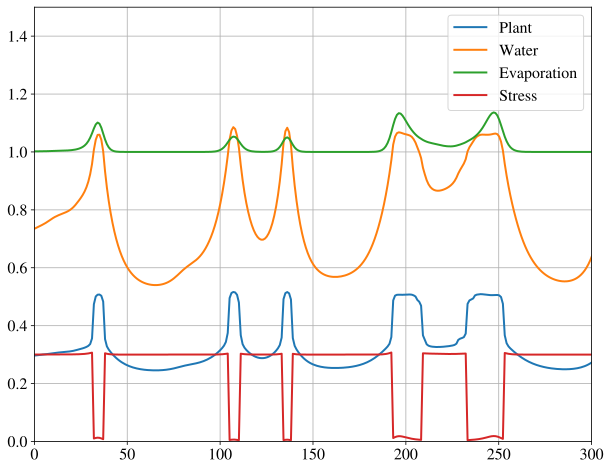

In [16]:
npx = np.linspace(0,n,n)
fig1, ax = plt.subplots(1, 1, figsize=(10, 8))
line10, = ax.plot(npx, Ps[100,:,99], lw=2, label='Plant'); 
line11, = ax.plot(npx, Ws[100,:,99], lw=2, label='Water'); 
line12, = ax.plot(npx, Es[100,:,99], lw=2, label='Evaporation'); 
line13, = ax.plot(npx, Ss[100,:,99], lw=2, label='Stress'); 
ax.set_xlim(0, 300)
ax.set_ylim(0, 1.5)
ax.legend()
ax.grid()
# plt.plot(Ys[100,:,99], label='Y stress'); 

# plt.plot(Ss[100,:,99], label='S water'); 

# plt.plot(As[100,:,99], label='A plant'); 

# plt.plot(Ps[100,:,99], label='P plant'); 

# plt.legend()
# plt.show()

### Making an animation

In [17]:
# from matplotlib import animation, rc
# import os
# if not os.path.exists("oldSim"):
#     os.makedirs("oldSim")

# def updatefig1(i): # To update the image at each iteration
#     global Ps, Ws, Es, Ss
#     line10.set_data( (npx,Ps[:,100,i]) )
#     line11.set_data( (npx,Ws[:,100,i]) )
#     line12.set_data( (npx,Es[:,100,i]) )
#     line13.set_data( (npx,Ss[:,100,i]) )
#     #text.set_text("Time: %1.0f of %1.0f" % ((i+1)/nplot*endTime, EndTime));
#     fig.savefig('oldSim/Sulfide'+str(i)+'.pdf')
#     return line10,line11,line12,line13
# ani = animation.FuncAnimation(fig1, updatefig1)

In [18]:
# from IPython.display import HTML
# HTML(ani.to_html5_video())

# # Writer = animation.writers['ffmpeg']
# # writer = Writer(fps=10, bitrate=1800)
# # ani.save('Crack based on Plant-Water-Evaporation-Stress_line.mp4', writer=writer)
# # print("Save movies finshes!")

© Kang, ECNU-Shanghai 20201218